In [1]:
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont

In [2]:
import fontconfig

# find a font file
fonts = fontconfig.query(lang='en')
for i in range(1, len(fonts)):
    if fonts[i].fontformat == 'TrueType':
        absolute_path = fonts[i].file
        
        print(absolute_path)
        break

/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf


In [3]:
image_file = json.load(open('../datasets/vg/image_data.json'))
vocab_file = json.load(open('../datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File('../datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [4]:
# load detected results
path = '../checkpoints/iba0.02_s2_inv_prop0.03_power0.5_sum_v3-predcls/'
detected_origin_path = path + 'inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [5]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = groundtruth.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    #mask = pred_rel_score > thres
    #pred_rel_score = pred_rel_score[mask]
    #pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [9]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    
    # get a font
    fnt = ImageFont.truetype(absolute_path, 14, encoding="unic")
    
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+100, y1+15)), fill=color)
        info = draw_info
        draw.text((x1, y1), info, font=fnt)

def print_list(name, input_list):
    for i, item in enumerate(input_list):
        print(name + ' ' + str(i) + ': ' + str(item))
    
def draw_image(img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels)
        print('*' * 50)
        print_list('gt_rels', gt_rels)
        print('*' * 50)
    print_list('pred_rels', pred_rels[:20])
    print('*' * 50)
    
    return None

In [10]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(cand_idx)
        draw_image(*get_info_by_idx(cand_idx, detected_origin_result))

0


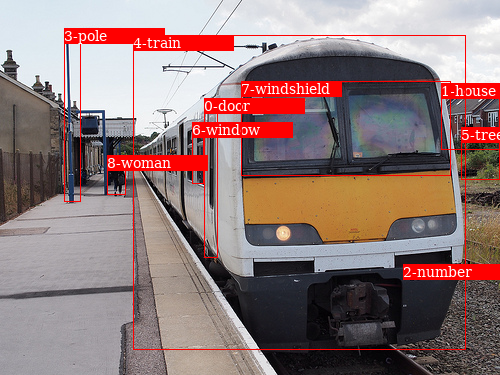

**************************************************
gt_boxes 0: 0-door
gt_boxes 1: 1-house
gt_boxes 2: 2-number
gt_boxes 3: 3-pole
gt_boxes 4: 4-train
gt_boxes 5: 5-tree
gt_boxes 6: 6-window
gt_boxes 7: 7-windshield
gt_boxes 8: 8-woman
**************************************************
gt_rels 0: ('7-windshield', 'on', '4-train')
gt_rels 1: ('6-window', 'on', '4-train')
gt_rels 2: ('4-train', 'has', '6-window')
gt_rels 3: ('1-house', 'near', '4-train')
gt_rels 4: ('5-tree', 'near', '1-house')
**************************************************
pred_rels 0: ('6-window', 'on', '4-train')
pred_rels 1: ('2-number', 'on', '4-train')
pred_rels 2: ('7-windshield', 'on', '4-train')
pred_rels 3: ('0-door', 'on', '4-train')
pred_rels 4: ('4-train', 'has', '7-windshield')
pred_rels 5: ('4-train', 'has', '0-door')
pred_rels 6: ('1-house', 'near', '4-train')
pred_rels 7: ('8-woman', 'near', '4-train')
pred_rels 8: ('4-train', 'has', '6-window')
pred_rels 9: ('4-train', 'has', '2-number')
pred_rels 10

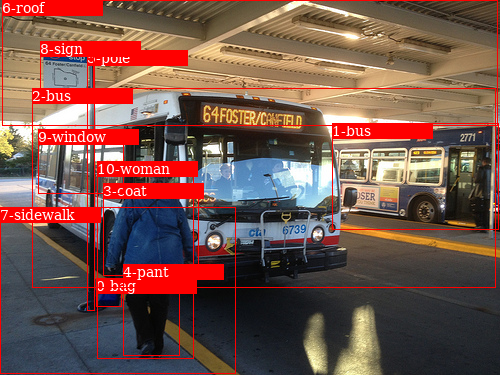

**************************************************
gt_boxes 0: 0-bag
gt_boxes 1: 1-bus
gt_boxes 2: 2-bus
gt_boxes 3: 3-coat
gt_boxes 4: 4-pant
gt_boxes 5: 5-pole
gt_boxes 6: 6-roof
gt_boxes 7: 7-sidewalk
gt_boxes 8: 8-sign
gt_boxes 9: 9-window
gt_boxes 10: 10-woman
**************************************************
gt_rels 0: ('2-bus', 'under', '6-roof')
gt_rels 1: ('10-woman', 'near', '2-bus')
gt_rels 2: ('9-window', 'on', '2-bus')
gt_rels 3: ('10-woman', 'wearing', '3-coat')
**************************************************
pred_rels 0: ('10-woman', 'wearing', '4-pant')
pred_rels 1: ('10-woman', 'wearing', '3-coat')
pred_rels 2: ('8-sign', 'hanging from', '6-roof')
pred_rels 3: ('10-woman', 'walking on', '7-sidewalk')
pred_rels 4: ('9-window', 'on', '2-bus')
pred_rels 5: ('8-sign', 'on', '5-pole')
pred_rels 6: ('10-woman', 'carrying', '0-bag')
pred_rels 7: ('10-woman', 'near', '2-bus')
pred_rels 8: ('3-coat', 'on', '10-woman')
pred_rels 9: ('6-roof', 'over', '2-bus')
pred_rels 10: (

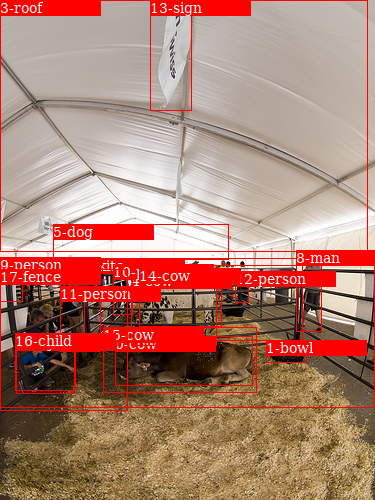

**************************************************
gt_boxes 0: 0-cow
gt_boxes 1: 1-bowl
gt_boxes 2: 2-boy
gt_boxes 3: 3-roof
gt_boxes 4: 4-cow
gt_boxes 5: 5-dog
gt_boxes 6: 6-fence
gt_boxes 7: 7-kite
gt_boxes 8: 8-man
gt_boxes 9: 9-person
gt_boxes 10: 10-person
gt_boxes 11: 11-person
gt_boxes 12: 12-person
gt_boxes 13: 13-sign
gt_boxes 14: 14-cow
gt_boxes 15: 15-cow
gt_boxes 16: 16-child
gt_boxes 17: 17-fence
**************************************************
gt_rels 0: ('13-sign', 'hanging from', '3-roof')
gt_rels 1: ('6-fence', 'near', '0-cow')
**************************************************
pred_rels 0: ('13-sign', 'hanging from', '3-roof')
pred_rels 1: ('0-cow', 'under', '3-roof')
pred_rels 2: ('15-cow', 'under', '3-roof')
pred_rels 3: ('14-cow', 'under', '3-roof')
pred_rels 4: ('10-person', 'watching', '4-cow')
pred_rels 5: ('1-bowl', 'on', '6-fence')
pred_rels 6: ('4-cow', 'under', '3-roof')
pred_rels 7: ('4-cow', 'behind', '6-fence')
pred_rels 8: ('2-boy', 'under', '5-dog')
p

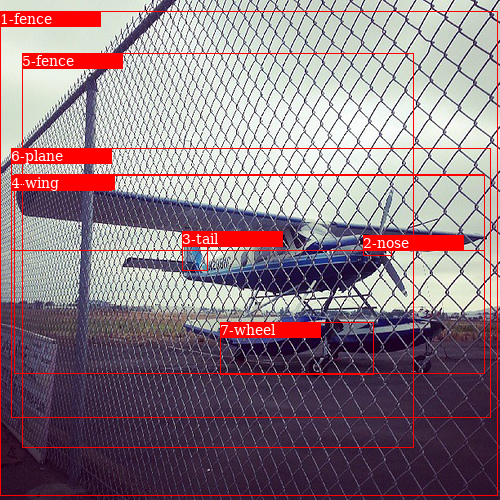

**************************************************
gt_boxes 0: 0-plane
gt_boxes 1: 1-fence
gt_boxes 2: 2-nose
gt_boxes 3: 3-tail
gt_boxes 4: 4-wing
gt_boxes 5: 5-fence
gt_boxes 6: 6-plane
gt_boxes 7: 7-wheel
**************************************************
gt_rels 0: ('4-wing', 'on', '6-plane')
gt_rels 1: ('0-plane', 'has', '3-tail')
gt_rels 2: ('1-fence', 'in front of', '0-plane')
gt_rels 3: ('7-wheel', 'on', '6-plane')
gt_rels 4: ('4-wing', 'on', '0-plane')
**************************************************
pred_rels 0: ('3-tail', 'on', '0-plane')
pred_rels 1: ('4-wing', 'on', '0-plane')
pred_rels 2: ('7-wheel', 'on', '0-plane')
pred_rels 3: ('0-plane', 'has', '3-tail')
pred_rels 4: ('7-wheel', 'on', '6-plane')
pred_rels 5: ('4-wing', 'on', '6-plane')
pred_rels 6: ('0-plane', 'has', '7-wheel')
pred_rels 7: ('0-plane', 'has', '4-wing')
pred_rels 8: ('0-plane', 'has', '2-nose')
pred_rels 9: ('3-tail', 'on', '6-plane')
pred_rels 10: ('2-nose', 'on', '0-plane')
pred_rels 11: ('6-plane'

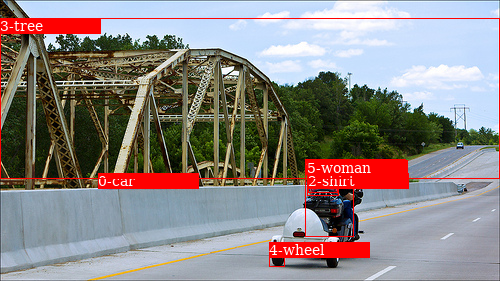

**************************************************
gt_boxes 0: 0-car
gt_boxes 1: 1-people
gt_boxes 2: 2-shirt
gt_boxes 3: 3-tree
gt_boxes 4: 4-wheel
gt_boxes 5: 5-woman
**************************************************
gt_rels 0: ('5-woman', 'wearing', '2-shirt')
gt_rels 1: ('5-woman', 'wearing', '2-shirt')
**************************************************
pred_rels 0: ('5-woman', 'wearing', '2-shirt')
pred_rels 1: ('1-people', 'wearing', '2-shirt')
pred_rels 2: ('2-shirt', 'on', '5-woman')
pred_rels 3: ('0-car', 'under', '3-tree')
pred_rels 4: ('3-tree', 'behind', '1-people')
pred_rels 5: ('3-tree', 'behind', '5-woman')
pred_rels 6: ('3-tree', 'behind', '0-car')
pred_rels 7: ('2-shirt', 'on', '1-people')
pred_rels 8: ('0-car', 'behind', '1-people')
pred_rels 9: ('5-woman', 'behind', '1-people')
pred_rels 10: ('0-car', 'behind', '5-woman')
pred_rels 11: ('1-people', 'near', '3-tree')
pred_rels 12: ('1-people', 'and', '5-woman')
pred_rels 13: ('5-woman', 'near', '3-tree')
pred_rels 14

In [11]:
show_all(start_idx=0, length=5)
#show_selected([119, 967, 713, 5224, 19681, 25371])